[![CyVers](https://i.imgur.com/yyhmZET.png)](https://www.cyvers.ai/)

# BlockChain Attack Data Set - Exploratory Data Analysis (EDA)

> Notebook by:
> - Royi Avital Royi@cyvers.ai

## Revision History

| Version | Date       | User        |Content / Changes                                                   |
|---------|------------|-------------|--------------------------------------------------------------------|
| 0.1.000 | 30/06/2022 | Royi Avital | First version                                                      |
| 0.2.000 | 25/07/2022 | Royi Avital | Added model selection and visualization of features                |
| 0.3.000 | 31/07/2022 | Royi Avital | Added a view of feature importance (Should be moved to a funciton) |
|         |            |             |                                                                    |

In [1]:
# General Tools
import numpy as np
import scipy as sp
import pandas as pd

# Misc
import datetime
import os
from platform import python_version
import random
import warnings

# EDA Tools
import ppscore as pps #<! See https://github.com/8080labs/ppscore -> pip install git+https://github.com/8080labs/ppscore.git

# Machine Learning
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
# from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

# Metrics
from sklearn.metrics import confusion_matrix, fbeta_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, StratifiedGroupKFold, train_test_split

# Ensemble Engines
from catboost import CatBoostClassifier, Pool
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

# Visualization
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from bokeh.plotting import figure, show

# Jupyter
from ipywidgets import interact, Dropdown, Layout

In [2]:
# Configuration
%matplotlib inline

warnings.filterwarnings("ignore")

seedNum = 512
np.random.seed(seedNum)
random.seed(seedNum)

sns.set_theme() #>! Apply SeaBorn theme

In [3]:
# Constants

DATA_FOLDER_NAME    = 'LazyGraphDataSet'#'BlockChainAttacksDataSet'
DATA_FOLDER_PATTERN = 'DataSet0'
DATA_FILE_EXT       = 'csv'

PROJECT_DIR_NAME = 'CyVers' #<! Royi: Anton, don't change it, it should be a team constant
PROJECT_DIR_PATH = os.path.join(os.getcwd()[:os.getcwd().find(PROJECT_DIR_NAME)], PROJECT_DIR_NAME) #>! Pay attention, it will create issues in cases you name the folder `CyVersMe` or anything after / before `CyVers`

# Feature extractors constants

TRAIN_BY_TSX    = 1
TRAIN_BY_FILES  = 2

In [4]:
# CyVers Packages
from DataSetsAuxFun import *

In [5]:
# Parameters
dataSetRotoDir = os.path.join(PROJECT_DIR_PATH, DATA_FOLDER_NAME)

# Features Analysis
numCrossValPps = 4

# Training
trainMode = TRAIN_BY_FILES
testSetRatio = 1 / 3
numKFolds = 3
gridSearchScore = 'f1' #<! Use strings from `sklearn.metrics.get_scorer_names()`
gridSearchScore = 'recall' #<! We need to have better PD

# Amount USD Outlier threshold
amountUsdOutlierThr = 1e9

randomState = 42

lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Currency Type', 'Amount [USD]', 'Receiver Type', 'Gas Price', 'Gas Limit', 'Gas Used' ]#lSlctedFeaturesRaw    = ['Amount', 'Currency', 'Amount [USD]', 'Receiver Type']
lSlctedFeaturesCalc   = [enumObj.name for enumObj in FeatureName if ((enumObj is not FeatureName.TIME_MAX) and (enumObj is not FeatureName.TIME_MIN))]
lSlctdFeatures        = lSlctedFeaturesRaw + lSlctedFeaturesCalc
lCatFeatures          = ['Currency', 'Currency Type', 'Receiver Type']#lCatFeatures          = ['Currency', 'Receiver Type']
# lFeaturesRemove       = [FeatureName.TIME_MAX.name, FeatureName.TIME_MIN.name] #<! Auxiliary features to be removed before processing

timeColStr = 'Block Time'

In [6]:
# Loading / Generating Data
lCsvFile = ExtractCsvFiles(dataSetRotoDir, folderNamePattern = DATA_FOLDER_PATTERN)
print(f'The number of file found: {len(lCsvFile)}')

#lCsvColName     = ['Transaction ID', 'Block Time', 'Transaction Time', 'Sender ID', 'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash', 'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used', 'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level']
#lCsvColNameFlag = [True,              True,         True,               True,        True,          True,            True,     True,       True,            True,            True,           True,        True,        True,       True,            True,         True,          False,   False]  #<! Flags if a column is a must to have
lCsvColName = [
'Transaction ID',
'Transaction Time',
'Block Time',	
'Sender ID',	
'Receiver ID',	
'Receiver Type',	
'Amount',	
'Currency',	
'Currency Hash',	
'Currency Type',	
'Amount [USD]',	
'Gas Price',	
'Gas Limit',	
'Gas Used',	
'Gas Predicted',	
'Balance In',	
'Balance Out',	
'Label',	
'Risk Level',	
'From Block Time',
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_transfer_date',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_first_transfer_date',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transfer_date',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transfer_date',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_total_transactions_USD_amount_in',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_transactions_USD_amount_out',	
'transactions_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_total_transfers_USD_amount_in',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_transfers_USD_amount_out',	
'transfers_receiverID_as_receiver_from_any_sender_first_received_amount',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_tranasctions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_tranasctions_count',	
'transactions_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transactions_count',	
'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transactions_count',	
'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_transfers_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_receivers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_transfers_count',	
'transfers_receiverID_as_receiver_from_any_sender_before_block_time_unique_senders_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_transfers_count',	
'transfers_senderID_as_sender_and_receiverID_as_receiver_before_block_time_unique_days_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_transfers_count',	
'transfers_senderID_as_receiver_and_receiverID_as_sender_before_block_time_unique_days_count',	
'total_transactions_count_between_sender_and_receiver_before_block_time',	
'total_transactions_unique_days_count_between_sender_and_receiver_before_block_time',	
'total_transfers_count_between_sender_and_receiver_before_block_time',	
'total_transfers_unique_days_count_between_sender_and_receiver_before_block_time',	
'transfers_first_transfer_date_between_senderID_receiverID_before_block_time',	
'transfers_days_count_between_senderID_and_receiverID_from_first_transfer_date_to_current_transaction_date',	
'transactions_first_transaction_date_between_senderID_receiverID_before_block_time',	
'transactions_days_count_between_senderID_and_receiverID_from_first_transaction_date_to_current_transaction_date',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_total_days_std',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_total_days_std',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_block_time_smart_contract_created',	
'transactions_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_receiver_annontation',	
'transfers_sent_or_received_unique_currency_count',	
'transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1',	
'transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_TxHash',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_TxHash',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_date',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_first_sent_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count',	
'transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count',	
'transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time',	
'transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time',	
'transfers_mixerID_and_receiverID_before_block_time_first_activity_date',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount',	
'transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one',	
'transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount',	
'transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count',	
'transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count',	
'transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date']	
lCsvColNameFlag = [
True,
False,
True,	
True,	
True,	
True,	
True,	
True,	
False,#'Currency Hash',	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True,	
True
]



# dfData = pd.read_csv(os.path.join(DATA_FOLDER_NAME, csvFileName))
#dfData, dAssetFile = LoadCsvFilesDf(lCsvFile, baseFoldePath = '')
dfData, dAssetFile =  LoadCsvFilesDf(lCsvFile, baseFoldePath = '', lColName = lCsvColName, lColFlag =  lCsvColNameFlag ,  addFileNameCol = True )

numRows, numCols = dfData.shape

print(f"The number of rows (Samples): {numRows}, The number of columns: {numCols}, number of unique sender id's: {dfData['Sender ID'].unique().shape}")
print(f'The data list of columns is: {dfData.columns} with {len(dfData.columns)} columns')

The number of file found: 117
The number of rows (Samples): 40296, The number of columns: 86, number of unique sender id's: (117,)
The data list of columns is: Index(['Transaction ID', 'Transaction Time', 'Block Time', 'Sender ID',
       'Receiver ID', 'Receiver Type', 'Amount', 'Currency', 'Currency Hash',
       'Currency Type', 'Amount [USD]', 'Gas Price', 'Gas Limit', 'Gas Used',
       'Gas Predicted', 'Balance In', 'Balance Out', 'Label', 'Risk Level',
       'From Block Time',
       'transactions_receiverID_as_receiver_from_any_sender_before_block_time_first_transaction_date',
       'transactions_receiverID_as_sender_to_any_receiver_before_block_time_first_transaction_date',
       'transactions_senderID_as_receiver_and_receiverID_as_sender_before_block_time_first_transaction_date',
       'transactions_senderID_as_sender_and_receiverID_as_receiver_before_block_time_first_transaction_date',
       'transfers_receiverID_as_receiver_from_any_sender_before_block_time_first_trans

In [7]:
# Convert time data into Pandas format
dfData[timeColStr] = pd.to_datetime(dfData[timeColStr], infer_datetime_format = 'True') #<! Stable time format

In [8]:
# Sort data by transaction date
dfData.sort_values(timeColStr, inplace = True)
# dfData.reset_index(drop = True, inplace = True)

In [9]:
# Meet the data
dfData.head(20)

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time,transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time,transfers_mixerID_and_receiverID_before_block_time_first_activity_date,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,File Name
14044,0x82ca4e875d300d61552b2546c2f51bb630cab4eb35ca...,NaN,2017-02-23 11:05:43+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x86ed2df3159171dd3fc8361ae0e7c59f46cf0ea7,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,0.0,1.0,Multisig002.csv
14043,0x4ae416a730584c4d529d9bbaa08d193d86abff3b0f5e...,NaN,2017-02-28 12:01:26+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xec466962b6d3e072f11ec455cc547178116290c8,Wallet,0.01,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14042,0x2025858cdebc50890745762750dbefedb6b6ce5066d2...,NaN,2017-03-23 11:37:47+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,6000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14041,0x3341bfb1d9fdac9ea7d8d8c3934fbdb79c2bc78525ab...,NaN,2017-03-24 13:36:38+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,8000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14034,0x29d83d0b0307ee07ab60249477193e9fe4169ee33169...,NaN,2017-03-28 09:31:02+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xa4e3e53e89e575b32249e6105da159a4f48d34de,Wallet,0.10,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,26.0,26.0,Multisig001.csv
14033,0x392fee353f3b9b74fb6461773d47807e4439c7648be8...,NaN,2017-03-28 11:09:50+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xa4e3e53e89e575b32249e6105da159a4f48d34de,Wallet,2.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,26.0,26.0,Multisig001.csv
14032,0x85529bcfd4cf817d8344676daaa80ebf1ff170d72c97...,NaN,2017-03-28 12:45:29+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb6f2af0b3551161fe95f18219a8d402fc4e0233b,Wallet,2.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,929.0,64.0,993.0,Multisig001.csv
14031,0x8244ac208337494bd17d37b3fda6b52b0cea90062ac3...,NaN,2017-03-29 15:43:45+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0x2cceda9171806afd2716367ca0a1359156728513,Smart Contract,2000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig001.csv
14040,0x8b8f6b1c3c62791def07e2dc220bf4fdcf8e7e9466c9...,NaN,2017-04-02 13:03:35+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0x0017185703fda419403449447dd534e90b1fea70,Wallet,1000.00,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Multisig002.csv
14039,0x7c1941c65e7e6f805c84d3e3a7773376d72ad0c47add...,NaN,2017-04-18 12:09:54+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515

# Information about the Data Before Pre Processing

1. See the labeled cases.
2. Count the Labels data.
3. Number of unique assets.
4. Pandas' `info()` and `describe()`.

After this phase, the data is _read only_.

In [10]:
# Look at attack cases
dfData.loc[dfData['Label'] == 1, :]

,Transaction ID,Transaction Time,Block Time,Sender ID,Receiver ID,Receiver Type,Amount,Currency,Currency Hash,Currency Type,...,transfers_anonymous_activity_from_mixerID_as_sender_to_receiverID_as_receiver_before_block_time,transfers_anonymous_activity_from_receiverID_as_sender_to_mixerID_as_receiver_before_block_time,transfers_mixerID_and_receiverID_before_block_time_first_activity_date,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount_less_equal_to_one,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date,File Name
14036,0x0e0d16475d2ac6a4802437a35a21776e5c9b681a77fe...,NaN,2017-07-18 22:33:23+00:00,0x91efffb9c6cd3a66474688d0a48aa6ecfe515aa5,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,26793.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,0.0,1.0,Multisig002.csv
14008,0x97f7662322d56e1c54bd1bab39bccf98bc736fcb9c7e...,NaN,2017-07-19 12:14:18+00:00,0x50126e8fcb9be29f83c6bbd913cc85b40eaf86fc,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,44055.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,3.0,4.0,Multisig001.csv
14048,0xeef10fc5170f669b86c4cd0444882a96087221325f8b...,NaN,2017-07-19 12:19:36+00:00,0xbec591de75b8699a3ba52f073428822d0bfc0d7e,0xb3764761e297d6f121e79c32a65829cd1ddb4d32,Wallet,82189.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,1.0,5.0,6.0,Multisig003.csv
13055,0x283fd14161d9841571acdc4b629de597bfdcdd197647...,NaN,2017-08-21 05:11:33+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,10.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Enigma001.csv
13054,0xa22dafd9184d9eb54deb021d2467eb4e4aee84aee121...,NaN,2017-08-21 05:18:32+00:00,0xa95842e41380100c12caf7b872baa77ce6d8ad24,0x29d7d1dd5b6f9c864d9db560d72a247c178ae86b,Wallet,7.000000,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,80.0,0.0,80.0,Enigma001.csv
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39798,0xecc404208cf5a9b817b772ca0d51c4bfa02eae2b31a6...,NaN,2022-09-15 21:11:47+00:00,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,0x6ae09ac63487fcf63117a6d6fafa894473d47b93,NaN,7.538739,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,0.0,0.0,0.0,Profanity001.csv
39803,0x64b7bbe7b879174663d88ca7ebad4ee7f0208a8699b8...,NaN,2022-09-16 07:12:11+00:00,0x00000000000cd56832ce5dfbcbff02e7ec639bc9,0x6ae09ac63487fcf63117a6d6fafa894473d47b93,NaN,0.000010,ETH,0x0000000000000000000000000000000000000000,NaN,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,11.0,0.0,11.0,Profanity001.csv
37999,0xbddb0cc8bc9949321e1748f03503ed1a20dd618fbf0a...,NaN,2022-09-16 08:49:47+00:00,0xa6439ca0fcba1d0f80df0be6a17220fed9c9038a,0x82faed2da812d2e5cced3c12b3baeb1a522dc677,NaN,200.000000,ETH,NaN,internal,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,2.0,89.0,91.0,Omni Bridge001.csv
38004,0xc3652f2ed07a9b7c60d7930ea1121c200585462ebfba...,NaN,2022-09-16 09:05:23+00:00,0xa6439ca0fcba1d0f80df0be6a17220fed9c9038a,0x82faed2da812d2e5cced3c12b3baeb1a522dc677,NaN,45.000000,ETH,NaN,internal,...,False,False,1970-01-01 00:00:00 +0000,0.0,True,0.0,2.0,89.0,91.0,Omni Bridge001.csv


In [11]:
# Balance of labels: Highly imbalanced data (As expected)
dfData['Label'].value_counts()

0    39708
1      588
Name: Label, dtype: int64

In [12]:
# How many unique `Sender ID` (Assets) we have.
# It should match the number of files, if not, it either means we have duplications or teh same asset was attacked twice.
len(dfData['Sender ID'].unique())

117

In [13]:
dfData['Label'].value_counts()

0    39708
1      588
Name: Label, dtype: int64

In [14]:
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40296 entries, 14044 to 39820
Data columns (total 86 columns):
 #   Column                                                                                                             Non-Null Count  Dtype              
---  ------                                                                                                             --------------  -----              
 0   Transaction ID                                                                                                     40296 non-null  object             
 1   Transaction Time                                                                                                   0 non-null      float64            
 2   Block Time                                                                                                         40296 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                             

In [15]:
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,transfers_sent_or_received_unique_currency_count,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date
count,0.0,4.029600e+04,3.865100e+04,4.029600e+04,4.029600e+04,4.029600e+04,0.0,0.0,0.0,40296.000000,...,40296.000000,40296.000000,40296.000000,40296.00000,40296.000000,40296.000000,4.029600e+04,4.029600e+04,40296.000000,4.029600e+04
mean,NaN,2.878698e+72,5.493991e+05,8.941369e-08,6.448385e+05,3.388815e+05,NaN,NaN,NaN,0.014592,...,70.794446,59.353583,45.726449,104.20739,99.285587,1199.010586,1.814721e+03,3.029089e+04,74.286306,3.036518e+04
std,NaN,5.778658e+74,6.901579e+06,1.211827e-07,1.635720e+06,1.231489e+06,NaN,NaN,NaN,0.119914,...,393.405928,330.604100,254.667809,806.58422,793.030841,15276.986563,3.035623e+04,3.746647e+05,2638.597270,3.746680e+05
min,NaN,0.000000e+00,0.000000e+00,1.000000e-10,2.100000e+04,1.936000e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,NaN,1.464938e-01,3.591788e+01,4.410000e-08,2.443980e+05,2.100000e+04,NaN,NaN,NaN,0.000000,...,2.000000,1.000000,1.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,NaN,1.379517e+00,4.138818e+02,7.000000e-08,2.500000e+05,1.116410e+05,NaN,NaN,NaN,0.000000,...,3.000000,3.000000,2.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,NaN,1.620499e+01,3.423018e+03,8.800000e-08,4.500000e+05,2.306078e+05,NaN,NaN,NaN,0.000000,...,14.000000,14.000000,4.000000,0.00000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
max,NaN,1.160000e+77,2.421620e+08,4.054923e-06,2.000000e+07,9.895111e+06,NaN,NaN,NaN,1.000000,...,8494.000000,8494.000000,5227.000000,9452.00000,10036.000000,461012.402344,1.223680e+06,8.640369e+06,522853.000000,8.640369e+06


# Pre Processing

1. Remove invalid data.
2. Remove outliers.

In [16]:
# Detecting invalid `Amount USD`

dsInValidTrnsUsd = ((dfData['Amount [USD]'] == 0) | (dfData['Amount [USD]'].isna()) | (dfData['Amount [USD]'] == ''))

print(f'Number of invalid `Amount [USD]`: {dsInValidTrnsUsd.sum()}')

Number of invalid `Amount [USD]`: 2461


In [17]:
# Remove invalid data
dfData.drop(dfData.index[dsInValidTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [18]:
# Detecting Outliers in the `Amount [USD]`

dsOutlierTrnsUsd = ((dfData['Amount [USD]'] >= amountUsdOutlierThr) | (dfData['Amount [USD]'] <= 0))

print(f'Number of outliers `Amount [USD]`: {dsOutlierTrnsUsd.sum()}')

Number of outliers `Amount [USD]`: 0


In [19]:
# Remove outliers
dfData.drop(dfData.index[dsOutlierTrnsUsd], inplace = True) #<! Royi: Should we do a reset index?

In [20]:
# From now on this is the data to work with
numRows, numCols = dfData.shape

print(f'The number of rows (Samples): {numRows}, The number of columns: {numCols}')

The number of rows (Samples): 37835, The number of columns: 86


# Meet the Data

Basic infomration about the data.

In [21]:
# Basic Data Information
dfData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 37835 entries, 14044 to 39820
Data columns (total 86 columns):
 #   Column                                                                                                             Non-Null Count  Dtype              
---  ------                                                                                                             --------------  -----              
 0   Transaction ID                                                                                                     37835 non-null  object             
 1   Transaction Time                                                                                                   0 non-null      float64            
 2   Block Time                                                                                                         37835 non-null  datetime64[ns, UTC]
 3   Sender ID                                                                                             

In [22]:
# Numeric Data Description
dfData.describe()

,Transaction Time,Amount,Amount [USD],Gas Price,Gas Limit,Gas Used,Gas Predicted,Balance In,Balance Out,Label,...,transfers_sent_or_received_unique_currency_count,transfers_any_sender_to_receiverID_as_receiver_before_block_time_unique_currency_count.1,transfers_receiverID_as_sender_to_any_receiver_before_block_time_unique_currency_count.1,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_received_transactions_count,transfers_mixerIDs_as_receiver_and_receiverID_as_sender_before_block_time_sent_transactions_count,transfers_mixerIDs_as_sender_and_receiverID_as_receiver_before_block_time_first_received_amount,transfers_receiverID_as_sender_and_mixerIDs_as_receiver_before_block_time_first_sent_amount,transactions_any_sender_to_receiverID_as_receiver_before_specified_time_transactions_count,transactions_receiverID_as_sender_to_any_receiver_before_specified_time_transactions_count,transactions_count_between_senderID_and_receiverID_before_block_time_before_first_transaction_date
count,0.0,3.783500e+04,3.783500e+04,3.783500e+04,3.783500e+04,3.783500e+04,0.0,0.0,0.0,37835.000000,...,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,37835.000000,3.783500e+04,3.783500e+04,37835.000000,3.783500e+04
mean,NaN,4.658518e+06,5.612482e+05,8.241747e-08,5.872607e+05,2.948535e+05,NaN,NaN,NaN,0.015435,...,59.416995,54.262270,35.333236,110.850985,105.742831,1218.362384,1.932421e+03,3.220730e+04,71.667900,3.227897e+04
std,NaN,2.631597e+08,6.975132e+06,1.093018e-07,1.530709e+06,1.134014e+06,NaN,NaN,NaN,0.123279,...,357.861108,330.042145,204.812629,831.969159,817.999564,15731.577396,3.132432e+04,3.864682e+05,2719.380672,3.864719e+05
min,NaN,1.000000e-18,2.750000e-20,1.000000e-10,2.100000e+04,2.008400e+04,NaN,NaN,NaN,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
25%,NaN,1.597481e-01,4.350269e+01,4.450000e-08,2.443980e+05,2.100000e+04,NaN,NaN,NaN,0.000000,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
50%,NaN,1.342191e+00,4.573282e+02,6.834697e-08,2.500000e+05,9.961000e+04,NaN,NaN,NaN,0.000000,...,3.000000,3.000000,2.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
75%,NaN,1.250000e+01,3.543951e+03,8.800000e-08,4.332390e+05,2.185510e+05,NaN,NaN,NaN,0.000000,...,12.000000,12.000000,4.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,0.000000e+00
max,NaN,2.786965e+10,2.421620e+08,4.054923e-06,2.000000e+07,9.895111e+06,NaN,NaN,NaN,1.000000,...,8494.000000,8494.000000,5227.000000,9452.000000,10036.000000,461012.402344,1.223680e+06,8.640369e+06,522853.000000,8.640369e+06


In [23]:
# How many times each hacker attacked
dsAttacksAsset = dfData[dfData['Label'] == 1]['Receiver ID'].value_counts()

print(f'There are {dsAttacksAsset.shape[0]} Attackers')
print(dsAttacksAsset.head(len(dsAttacksAsset))) #<! Last ones should be 1

There are 67 Attackers
0x3aa27ab297a3a753f79c5497569ba2dacc2bc35a    106
0xb9864cebcc27136eb4657ffef534956eac78c15c    104
0x3f8a37bde9b15b65c82f9cdd00192e0ba36cc5fc     46
0x941a9e3b91e1cc015702b897c512d265fae88a9c     28
0x0000000a5aab7e0b99e8b30028d790de05da0f09     28
                                             ... 
0x601a1dd67a637fc3ff0141724152e15abe1905f7      1
0x03d1d0e4061152c6a698309aaa4968aae58585a8      1
0x3668c746398621d26f1f7b02f03276be586096d1      1
0x7c42f2a7d9ad01294ecef9be1e38272c84607593      1
0xeda5066780de29d00dfb54581a707ef6f52d8113      1
Name: Receiver ID, Length: 67, dtype: int64


Text(0, 0.5, 'Number of Attackers')

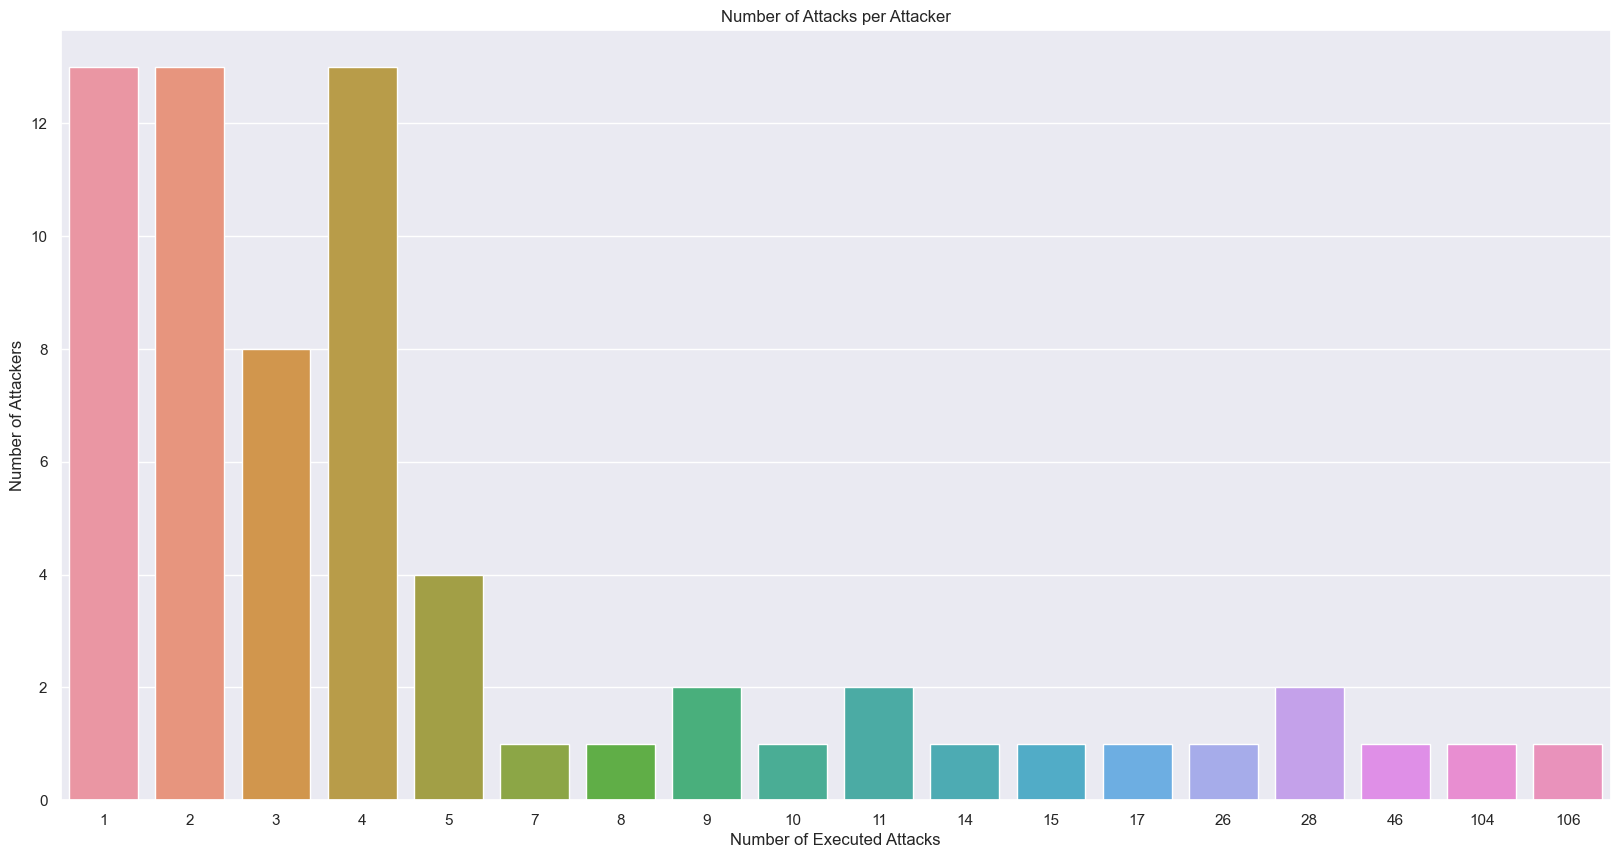

In [24]:
hF, hA = plt.subplots(figsize = (20, 10)) # 
sns.countplot(dsAttacksAsset, ax = hA)
hA.set_title('Number of Attacks per Attacker')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Attackers')

In [25]:
# How many times each asset was attacked?
dsSenderCount = dfData[dfData['Label'] == 1]['Sender ID'].value_counts()

Text(0, 0.5, 'Number of Assets')

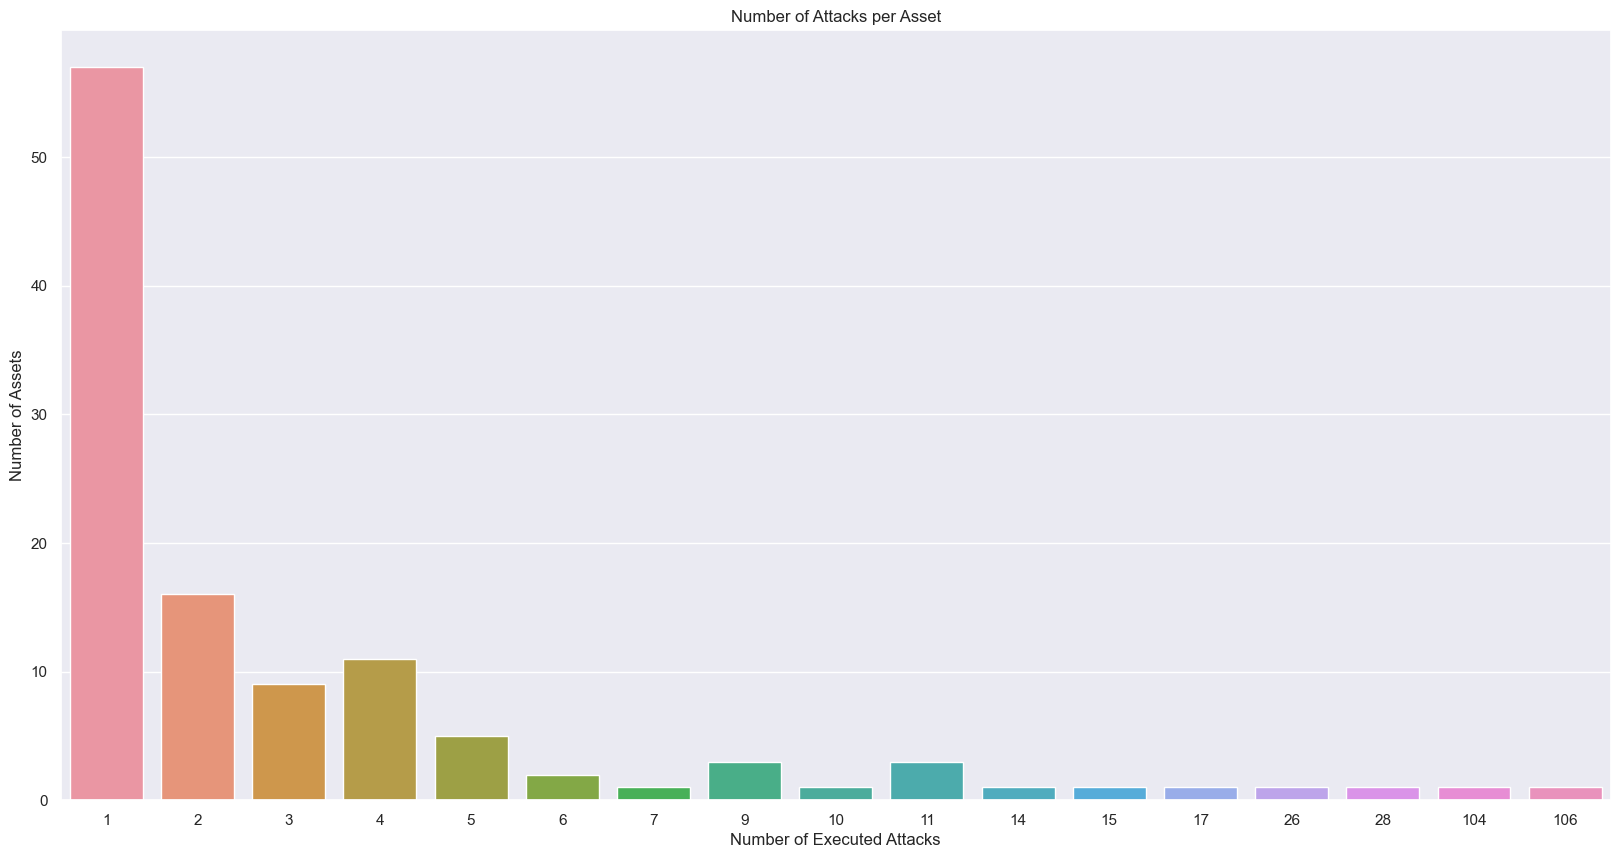

In [26]:
hF, hA = plt.subplots(figsize = (20, 10)) # TODO: Display an histogram (How many assets were attacked 1, 2, ...)
sns.countplot(dsSenderCount, ax = hA)
hA.set_title('Number of Attacks per Asset')
hA.set_xlabel('Number of Executed Attacks')
hA.set_ylabel('Number of Assets')

In [27]:
# How many different assets each attacker attacked? How many times per asset?
dsAttacksIdAttacker = dfData[dfData['Label'] == 1].groupby(['Receiver ID', 'Sender ID'])['Transaction ID'].count().reset_index(name = 'Number of Attacks')  
dsAttacksIdAttacker.head(40)

,Receiver ID,Sender ID,Number of Attacks
0,0x0000000a5aab7e0b99e8b30028d790de05da0f09,0xb314fd4ac6e10a7e27929cbc8db96743739c82b6,28
1,0x03d1d0e4061152c6a698309aaa4968aae58585a8,0x2f2ca827b3c2c57d554d08698e10c3d8016e9f81,1
2,0x05605a807f4444f8c2fdbc44f51717ab6c055cd2,0x6fb209016b489977ecc78abf3eb5a8613e7ac728,4
3,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x478c070341265d5fc563512ad7c9c6481a4a3a24,1
4,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x6a14fdcbf6fec2f7221b54536279932582f9964c,1
5,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x785038e55c3c77256bdc9a03535fd3e8d948a116,1
6,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0x87654f58faff71f04291b293e4af2d52dcbe7f15,1
7,0x0b283b107f70d23250f882fbfe7216c38abbd7ca,0xe693e36cf773f4a47eb03d46666ee5116e04afd5,1
8,0x0d043128146654c7683fbf30ac98d7b2285ded00,0x9e91ae672e7f7330fc6b9bab9c259bd94cd08715,9
9,0x0e57edba0fccb1e388926193c873120cab961fee,0x4ba7c86c929d9f00d8a09c847ea05fc817ad03b6,1


In [28]:
# Initialize the Pandas Extension (Don't change the Index from now on!)
numGrps = dfData.GrpBySender.numGrps

### SASA vs. SAMA Cases

Definitions:

 * SASA:
 * SAMA:

**Remark**: Move to:

SASASW - Single Asset, Single   Attacks, Single   Wallets  
SAMASW - Single Asset, Multiple Attacks, Single   Wallets (SAMA)  
SAMAMW - Single Asset, Multiple Attacks, Multiple Wallets (SAMA)  

In [29]:
# Analysis of Attack Type
# !!! The function `CalcAttackType()` uses the Pandas extension, hence it should be initialized before!
dsAttackType, dfAttackType = CalcAttackType(dfData)

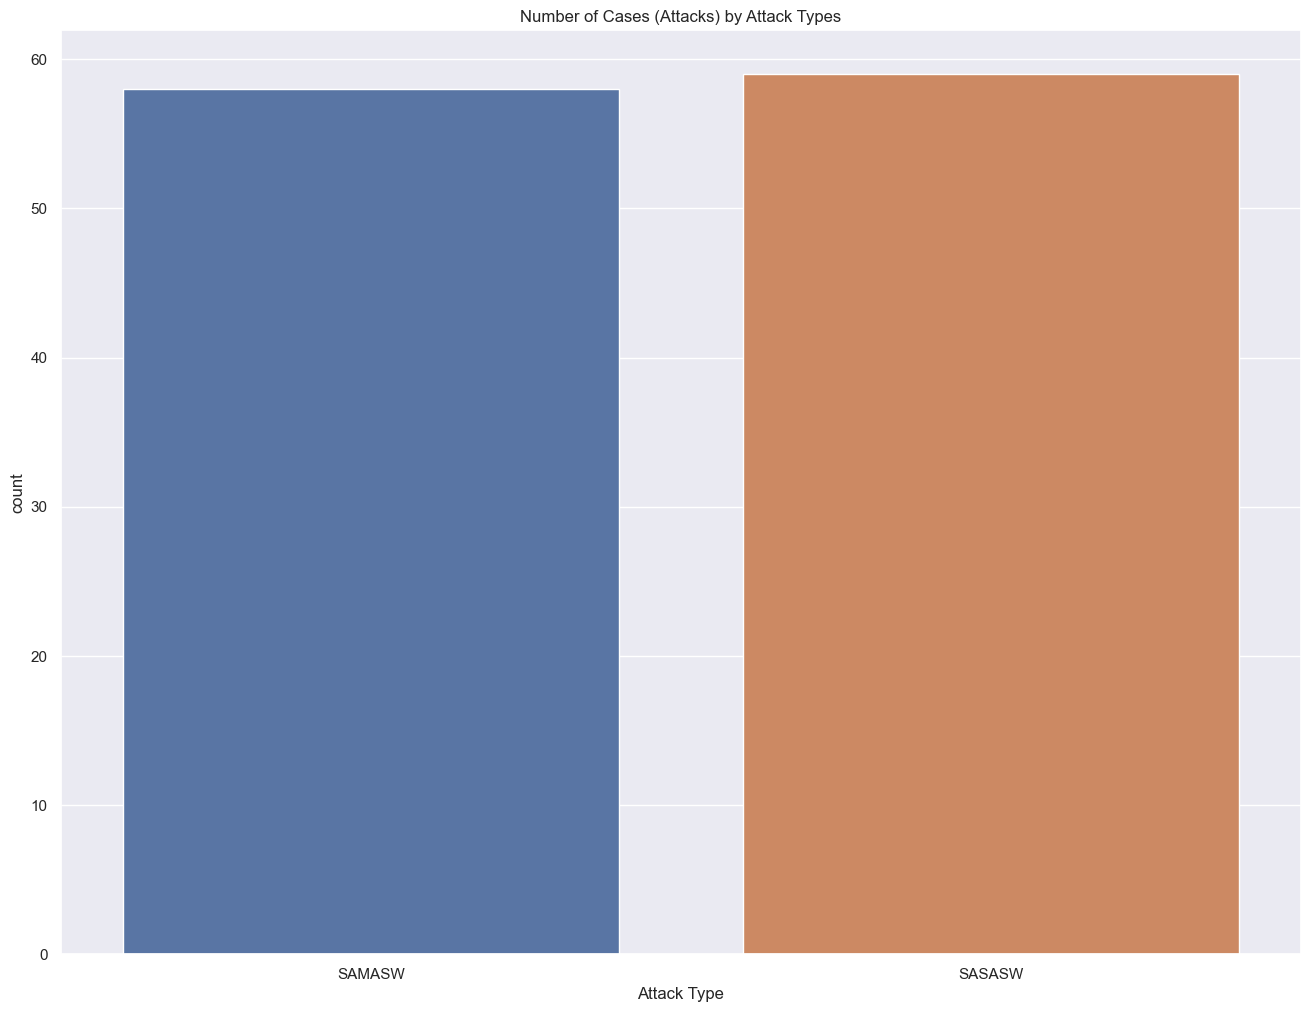

In [30]:
# Display an Histogram of the Attack Types
hF, hA = plt.subplots(figsize = (16, 12))
sns.countplot(x = dfAttackType['Attack Type'], ax = hA)
hA.set_title('Number of Cases (Attacks) by Attack Types')
plt.show()

## Feature Engineering

This section adds features and engineers them.  
Most features work on the `Sender ID` group.

#### Amount Based Features:

1. The STD of the user vs the average STD of all other users of the asset.
2. The Median of the user vs the average STD of all other users of the asset.
3. 

#### Date Based Features

1. The day of the week.
2. Weekend.
3. Hour of the day.
4. STD fo the time difference of the user vs. the avergae of all other users.
5. Median fo the time difference of the user vs. the avergae of all other users.

**Remark**: For wallets with a lot of activity we need to analyze the "activity hours" and profile it.


The features are:

 1. Day of the Week.

Remarks:

 *  Features x-y are time / frequency related.
 *  Features z-t are trasnaction realted.


In [31]:
# Pre Process

dfGbs = dfData.GrpBySender

### Features per Asset

In [32]:
# Features - Amount Based

sum_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggBySender(colName = dfGbs.amountUSDColLabel, grpLabel = None, calcType = CalcType.TYPE_MAX)
coint_c         = dfGbs.AggBySender(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggBySender(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE)

gas_pr_mean     = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_pr_std      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_pr_med      = dfGbs.AggBySender(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggBySender(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggBySender(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)


dfData[FeatureName.AMOUNT_SUM_ASSET.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_ASSET.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_ASSET.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_ASSET.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_ASSET.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_ASSET.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_ASSET.name]          = max_s
dfData[FeatureName.TSX_COUNT_ASSET.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_ASSET.name]     = coint_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_ASSET.name] = receiver_type_c

dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_ASSET.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_ASSET.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_ASSET.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_ASSET.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_ASSET.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_ASSET.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_ASSET.name] = gas_used_med

#COIN_TYPE_COUNT_USR                 

In [33]:
# Features - Time Based

td_mean_s   = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggBySender(colName = dfGbs.timeDiffAssetColLabel, grpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_ASSET.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_ASSET.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_ASSET.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_ASSET.name]    = td_max_s

### Features per User

In [34]:
# Features - Amount Based (User)

sum_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_SUM)
mean_s          = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEAN)
std_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_STD)
var_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_VAR)
median_s        = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MEDIAN)
count_s         = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_COUNT)
min_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)
max_s           = dfGbs.AggByReceiver(colName = dfGbs.amountUSDColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
coin_c          = dfGbs.AggByReceiver(colName = dfGbs.currencyColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_COIN_TYPE)
receiver_type_c = dfGbs.AggByReceiver(colName = dfGbs.receiverTypeColLabel, grpLabel = None, calcType = CalcType.TYPE_COUNT_RECEIVER_TYPE) #<! Royi: We need to check why is it so important?!?!

gas_pr_mean     = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_lim_mean    = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)
gas_used_mean   = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEAN)

gas_pr_std      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_lim_std     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)
gas_used_std    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_STD)

gas_pr_med      = dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_lim_med     = dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)
gas_used_med    = dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_MEDIAN)

gas_pr_quant    = dfGbs.dfSubGrpByRec[dfGbs.gasPriceColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasPriceColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_lim_quant   = dfGbs.dfSubGrpByRec[dfGbs.gasLimitColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasLimitColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)
gas_used_quant  = dfGbs.dfSubGrpByRec[dfGbs.gasUsedColLabel].transform('quantile' ,q =0.75)#dfGbs.AggByReceiver(colName = dfGbs.gasUsedColLabel, grpLabel = None, calcType = CalcType.TYPE_PCTILE)


dfData[FeatureName.AMOUNT_SUM_USR.name]          = sum_s
dfData[FeatureName.AMOUNT_MEAN_USR.name]         = mean_s
dfData[FeatureName.AMOUNT_STD_USR.name]          = std_s
dfData[FeatureName.AMOUNT_VAR_USR.name]          = var_s
dfData[FeatureName.AMOUNT_MEDIAN_USR.name]       = median_s
dfData[FeatureName.AMOUNT_MIN_USR.name]          = min_s
dfData[FeatureName.AMOUNT_MAX_USR.name]          = max_s
dfData[FeatureName.TSX_COUNT_USR.name]           = count_s
dfData[FeatureName.COIN_TYPE_COUNT_USR.name]     = coin_c
dfData[FeatureName.RECEIVER_TYPE_COUNT_USR.name] = receiver_type_c    

dfData[FeatureName.GAS_PRICE_MEAN_USR.name] = gas_pr_mean
dfData[FeatureName.GAS_PRICE_STD_USR.name] = gas_pr_std
dfData[FeatureName.GAS_PRICE_MEDIAN_USR.name] = gas_pr_med

dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] = gas_lim_mean
dfData[FeatureName.GAS_LIMIT_STD_USR.name] = gas_lim_std
dfData[FeatureName.GAS_LIMIT_MEDIAN_USR.name] = gas_lim_med

dfData[FeatureName.GAS_USED_MEAN_USR.name] = gas_used_mean
dfData[FeatureName.GAS_USED_STD_USR.name] = gas_used_std
dfData[FeatureName.GAS_USED_MEDIAN_USR.name] = gas_used_med

dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name] = gas_pr_quant
dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name] = gas_lim_quant
dfData[FeatureName.GAS_USED_QUANTILE_USR.name] = gas_used_quant


In [35]:
# Features - Time Based (User)

td_mean_s   = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEAN)
td_std_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_STD)
td_median_s = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MEDIAN)
td_min_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MIN)
td_max_s    = dfGbs.AggByReceiver(colName = dfGbs.timeDiffUserColLabel, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_TIME_DIFF_MAX)

dfData[FeatureName.TIME_DIFF_MEAN_USR.name]   = td_mean_s
dfData[FeatureName.TIME_DIFF_STD_USR.name]    = td_std_s
dfData[FeatureName.TIME_DIFF_MEDIAN_USR.name] = td_median_s
dfData[FeatureName.TIME_DIFF_MIN_USR.name]    = td_min_s
dfData[FeatureName.TIME_DIFF_MAX_USR.name]    = td_max_s

### Features based on Transaction Time

In [36]:
# Features - Time Based

dfData[FeatureName.TIME_HOUR.name]    = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.HOUR_DAY)
dfData[FeatureName.TIME_WEEKDAY.name] = dfGbs.GetTimeVals(periodTimeType = PeriodTimeType.DAY_WEEK)

### Features based on Ratios

In [37]:
# Ratio Based Features

dfData[FeatureName.AMOUNT_MEAN_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_MEAN_USR.name] / dfData[FeatureName.AMOUNT_MEAN_ASSET.name]
dfData[FeatureName.AMOUNT_STD_RATIO_USR_ASSET.name]    = dfData[FeatureName.AMOUNT_STD_USR.name] / dfData[FeatureName.AMOUNT_STD_ASSET.name]
dfData[FeatureName.TIME_DIFF_MEAN_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_MEAN_USR.name] / dfData[FeatureName.TIME_DIFF_MEAN_ASSET.name]
dfData[FeatureName.TIME_DIFF_STD_RATIO_USR_ASSET.name] = dfData[FeatureName.TIME_DIFF_STD_USR.name] / dfData[FeatureName.TIME_DIFF_STD_ASSET.name]

### Features based on Frequency

In [38]:
# Frequency Based Features

dfData[FeatureName.TIME_MAX.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MAX)
dfData[FeatureName.TIME_MIN.name] = dfGbs.AggByReceiver(colName = timeColStr, grpLabel = None, subGrpLabel = None, calcType = CalcType.TYPE_MIN)

dfData[FeatureName.TIME_INTERVL_USR.name] = ((dfData[FeatureName.TIME_MAX.name] - dfData[FeatureName.TIME_MIN.name])).dt.total_seconds()

# Frequency of the User Transactions
dfData[FeatureName.TSX_FREQ_HZ_USR.name] = dfData[FeatureName.TSX_COUNT_USR.name] / dfData[FeatureName.TIME_INTERVL_USR.name]

### Gas ratio features(experimental)

In [39]:
#Ratios between the user to the mean of all users.
dfData[FeatureName.GAS_PRICE_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_ASSET.name]
dfData[FeatureName.GAS_LIMIT_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_LIMIT_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_ASSET.name]
dfData[FeatureName.GAS_USED_USR_ASSET_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_ASSET.name] 
#Gas Price', 'Gas Limit', 'Gas Used'
dfData[FeatureName.GAS_PRICE_LIMIT_RATIO.name] = dfData['Gas Price'] / dfData['Gas Limit']
dfData[FeatureName.GAS_PRICE_USED_RATIO.name] = dfData['Gas Price'] / dfData['Gas Used']
dfData[FeatureName.GAS_USED_LIMIT_RATIO.name] = dfData['Gas Used'] / dfData['Gas Limit'] 

dfData[FeatureName.GAS_PRICE_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_LIMIT_MEAN_USR.name]
dfData[FeatureName.GAS_PRICE_USED_RATIO_MEAN.name] = dfData[FeatureName.GAS_PRICE_MEAN_USR.name] / dfData[FeatureName.GAS_USED_MEAN_USR.name]
dfData[FeatureName.GAS_USED_LIMIT_RATIO_MEAN.name] = dfData[FeatureName.GAS_USED_MEAN_USR.name] / dfData[FeatureName.GAS_PRICE_MEAN_USR.name] 


#Compare it to 75 quantile (TSX Gas Price / Quantile(75) of Gas Price).
dfData[FeatureName.GAS_PRICE_QUANTILE_RATIO.name] = dfData['Gas Price'] / dfData[FeatureName.GAS_PRICE_QUANTILE_USR.name]
dfData[FeatureName.GAS_LIMIT_QUANTILE_RATIO.name] = dfData['Gas Limit'] / dfData[FeatureName.GAS_LIMIT_QUANTILE_USR.name]
dfData[FeatureName.GAS_USED_QUANTILE_RATIO.name] =  dfData['Gas Used'] / dfData[FeatureName.GAS_USED_QUANTILE_USR.name]

In [40]:
#Feature to indicate first transaction
dfData[FeatureName.MIN_INDICATOR.name] = 0 ; dfData.loc[dfData[timeColStr] == dfData[FeatureName.TIME_MIN.name], FeatureName.MIN_INDICATOR.name] = 1 
### TODO !!! this can be invorrect. it will need a review !!!!!! 

In [41]:
#56
#Create features based on the currency of the transactions:
# 1. The number of different types of currencies per user. <-- done previously = dfData[FeatureName.COIN_TYPE_COUNT_USR.name]
# 2. The average of the number of types of all user for an asset. <-- groupby asset , mean(number of different types of currencies per user)
# 3. The ratio between a specific user to the average of the asset. --> 1/2
    

dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]    = dfGbs.AvgByUserCoinType()
dfData[FeatureName.COIN_TYPE_USR_MEAN_ASSET_RATIO.name]  = dfData[FeatureName.COIN_TYPE_COUNT_USR.name] / dfData[FeatureName.COIN_TYPE_COUNT_USR_MEAN_ASSET.name]


## Features Visualization

In [ ]:
numFeatures     = len(lSlctdFeatures)

In [ ]:
# Display the Scatter of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayScatterFeature(dfData, 'Label', yColName, 'Suspicious'), yColName = oDropdwon)

In [ ]:
# Display the Density of the Features

oDropdwon = Dropdown(
    options     = lSlctdFeatures,
    value       = 'Amount [USD]',
    description = 'Select Feature:',
    style       = {'description_width' : 'initial'}
)

interact(lambda yColName: DisplayKdeFeature(dfData, yColName, 'Label', 'Suspicious'), yColName = oDropdwon)

## Features Pre Processing (For Training Phase)

In [42]:
dfData_ = dfData.copy(deep=True) ###<<-- I create a copy of data frame for experiment with categorical variables 

In [ ]:
# Pre Processing Data
dfData.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData.fillna(0, inplace = True)
dfX = dfData[lSlctdFeatures].copy()
for catColName in lCatFeatures:
    dfX[catColName], _ =  pd.factorize(dfX[catColName])

In [ ]:
# Input Data for Classifier

lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]

mX = dfX[lNumericalFeatures].to_numpy()
mC = dfX[lCatFeatures].to_numpy()
vY = dfData['Label'].to_numpy()
# Scaling the data
hStdScaler = StandardScaler() #<! Don't touch categorial data
mX = hStdScaler.fit_transform(mX)
mX = np.concatenate((mX, mC), axis = 1)

### Display the PPS Matrix

The idea is to see the relationship between the features not by a linear correlation but by the ability to predict them.

In [ ]:
# Creating the DF for the PPS analysis
dfTmp = dfData[lSlctdFeatures + ['Label']].copy()

for featureName in (lCatFeatures + ['Label']):
    dfTmp[featureName] = pd.Categorical(dfTmp[featureName])  

In [ ]:
# Feature PPS - Which featuers are important?

# Pay attention, cross validation is K-Fold -> Don't over split the data
mPPS = pps.matrix(dfTmp, **{'cross_validation': numCrossValPps, 'random_seed': randomState})[['x', 'y', 'ppscore']].pivot(columns = 'x', index = 'y', values = 'ppscore') #<! We should set `Label` as a categorial variable

# Visualization of PPS
hF, hA = plt.subplots(figsize = (30, 30))
sns.heatmap(mPPS, annot = True, fmt = '.2f', cmap = plt.get_cmap('coolwarm'), cbar = False, vmin = 0, vmax = 1, ax = hA) 

plt.setp(hA.get_xticklabels(), ha = "center", rotation = 45)
plt.setp(hA.get_yticklabels(), rotation = 'horizontal')
hA.set_title('Predictive Power Score (PPS)')

In [ ]:
# Validation the columns are legit
dfX.columns

## Model Training and Evaluation

### Classic Train Test Split

In [ ]:
mXTrain, mXTest, vYTrain, vYTest = train_test_split(mX, vY, test_size = testSetRatio, random_state = randomState, stratify = vY)

In [ ]:
xgbModel = XGBClassifier(use_label_encoder = False)
xgbModel.fit(mXTrain, vYTrain)
vYPred = xgbModel.predict(mXTest)

In [ ]:
DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)

In [ ]:
dsScoreSumm = GenClassifierSummaryResults(vYTest, vYPred)
dfScoreSummary  = pd.DataFrame(dsScoreSumm, columns = ['Score'])
dfScoreSummary

### K Fold Training

In [ ]:
# Training by Transactions (K-Fold)
hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrinIdx, vTestIdx in hKFoldSplt.split(mX, vY):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrinIdx, :], mX[vTestIdx, :], vY[vTrinIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

In [ ]:
lTotalFeatures = lNumericalFeatures + lCatFeatures
len(lTotalFeatures)

In [ ]:
dfFeatures = pd.DataFrame(data = list(zip(lTotalFeatures, xgbModel.feature_importances_)), columns = ['Feature Name', 'Feature Importance'])

In [ ]:
hF, hA = plt.subplots(figsize = (32, 8))
sns.barplot(data = dfFeatures, x = 'Feature Name', y = 'Feature Importance', ax = hA)
plt.setp(hA.get_xticklabels(), rotation = 90)
plt.show()

In [ ]:
# Pre Processing data to match the text indices
vTetsIdxDf = dfData.index[vTestIdx]
dAttackTypeName = {}
for attackTypeEnum in AttackType:
    dAttackTypeName[attackTypeEnum.value] = attackTypeEnum.name


In [ ]:
GenClassifierSummaryResultsGrp(vYTest, vYPred, vGrpLabel = dsAttackType[vTetsIdxDf].to_numpy(), dGrpName = dAttackTypeName) #<! Results don't look reasonable

In [ ]:
# Training by Files (K-Fold)
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX[vTrainIdx, :], mX[vTestIdx, :], vY[vTrainIdx], vY[vTestIdx]
    xgbModel = XGBClassifier(use_label_encoder = False)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

### K-fold training, using categorical variables (EXPERIMENT)

In [43]:
###### only pd.df approach is working, numpy(dtype=object) didn't work so it is not represented
#make sure below lists are defined
lNumericalFeatures = [featureName for featureName in lSlctdFeatures if featureName not in lCatFeatures]
lTotalFeatures = lNumericalFeatures + lCatFeatures
feature_types_ = ['c' if x in lCatFeatures  else 'float' for x in lTotalFeatures]#feature_types_ = ['c' if x in lCatFeatures  else float for x in lTotalFeatures]

In [44]:
# Pre Processing Data categorical mine, here dfData_ <-- is used for experiment

dfData_.replace([np.inf, -np.inf], np.nan, inplace = True)
dfData_.fillna(0, inplace = True)
dfX_ = dfData_[lSlctdFeatures].copy()

for catColName in lCatFeatures:
    dfX_[catColName] = dfX_[catColName].astype("category", copy = False)
hStdScaler = StandardScaler()
dfX_[lNumericalFeatures] = hStdScaler.fit_transform(dfX_[lNumericalFeatures])


In [45]:
mX = dfX_[lTotalFeatures]
mX.rename(columns = {'Amount [USD]':'Amount USD'}, inplace = True)
vY = dfData_['Label']


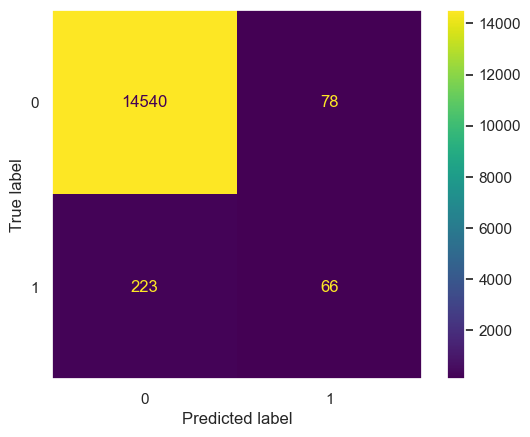

Accuracy         0.979808
F1               0.304850
Precision        0.458333
Recall           0.228374
ROC AUC Score    0.611519
dtype: float64


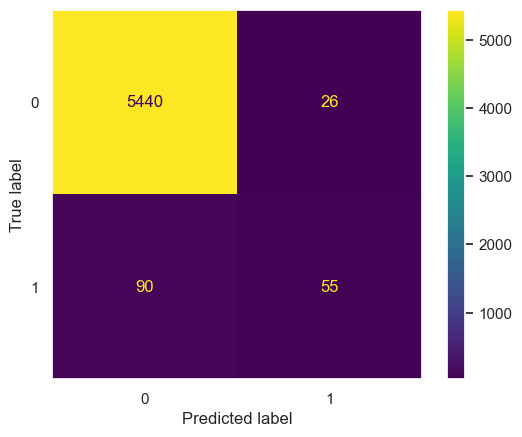

Accuracy         0.979326
F1               0.486726
Precision        0.679012
Recall           0.379310
ROC AUC Score    0.687277
dtype: float64


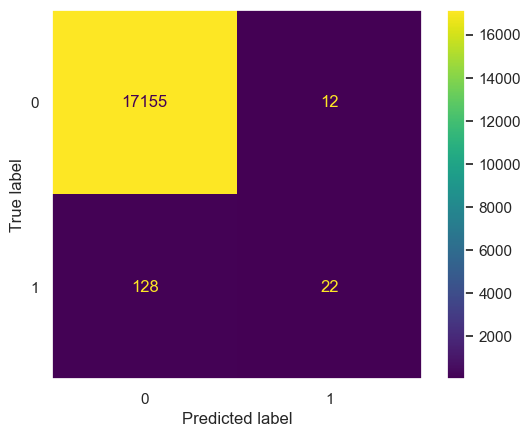

Accuracy         0.991915
F1               0.239130
Precision        0.647059
Recall           0.146667
ROC AUC Score    0.572984
dtype: float64


In [46]:
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=250, tree_method="hist", max_depth = 20,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))

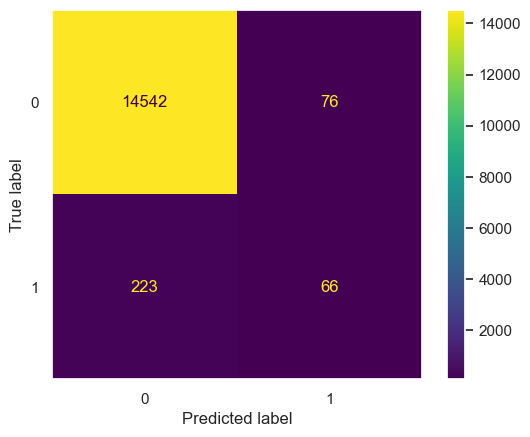

Accuracy         0.979942
F1               0.306265
Precision        0.464789
Recall           0.228374
ROC AUC Score    0.611587
dtype: float64


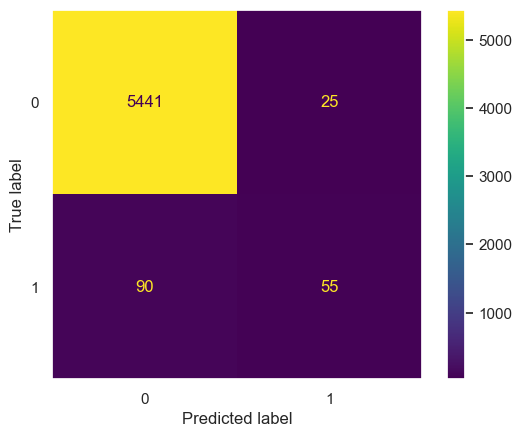

Accuracy         0.979505
F1               0.488889
Precision        0.687500
Recall           0.379310
ROC AUC Score    0.687368
dtype: float64


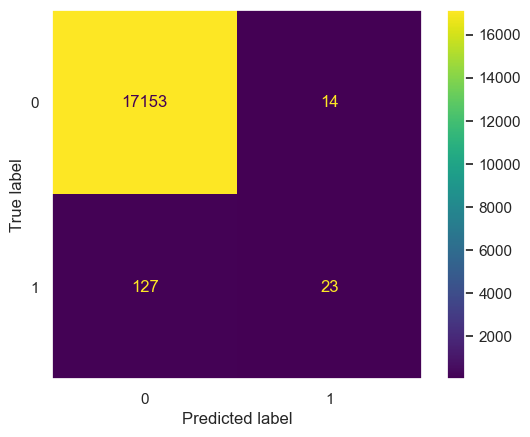

Accuracy         0.991858
F1               0.245989
Precision        0.621622
Recall           0.153333
ROC AUC Score    0.576259
dtype: float64


In [48]:
models = []
hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
for vTrainIdx, vTestIdx in hKFoldSplt.split(mX, vY, groups = dfData_['Sender ID']):
    mXTrain, mXTest, vYTrain, vYTest = mX.iloc[vTrainIdx], mX.iloc[vTestIdx], vY.iloc[vTrainIdx], vY.iloc[vTestIdx]
    #xgbModel =XGBClassifier(tree_method="gpu_hist", max_depth = 20, feature_names = lTotalFeatures, feature_types = feature_types_, random_state=seedNum, enable_categorical=True) #XGBClassifier(use_label_encoder = False)
    xgbModel =XGBClassifier(n_estimators=750, tree_method="hist", max_depth = 7,  random_state=seedNum, enable_categorical=True)
    xgbModel.fit(mXTrain, vYTrain)
    vYPred = xgbModel.predict(mXTest)
    DisplayConfusionMatrix(vYTest, vYPred, lClasses = xgbModel.classes_)
    print(GenClassifierSummaryResults(vYTest, vYPred))
    models.append([vTrainIdx , vTestIdx , xgbModel])

In [52]:
mX.columns

Index(['Amount', 'Amount USD', 'Gas Price', 'Gas Limit', 'Gas Used',
       'AMOUNT_SUM_ASSET', 'AMOUNT_SUM_USR', 'AMOUNT_MEAN_ASSET',
       'AMOUNT_MEAN_USR', 'AMOUNT_STD_ASSET', 'AMOUNT_STD_USR',
       'AMOUNT_VAR_ASSET', 'AMOUNT_VAR_USR', 'AMOUNT_MEDIAN_ASSET',
       'AMOUNT_MEDIAN_USR', 'AMOUNT_MIN_ASSET', 'AMOUNT_MIN_USR',
       'AMOUNT_MAX_ASSET', 'AMOUNT_MAX_USR', 'TIME_DIFF_MEAN_ASSET',
       'TIME_DIFF_MEAN_USR', 'TIME_DIFF_STD_ASSET', 'TIME_DIFF_STD_USR',
       'TIME_DIFF_MEDIAN_ASSET', 'TIME_DIFF_MEDIAN_USR', 'TIME_DIFF_MIN_ASSET',
       'TIME_DIFF_MIN_USR', 'TIME_DIFF_MAX_ASSET', 'TIME_DIFF_MAX_USR',
       'COIN_TYPE_COUNT_ASSET', 'COIN_TYPE_COUNT_USR_MEAN_ASSET',
       'COIN_TYPE_USR_MEAN_ASSET_RATIO', 'COIN_TYPE_COUNT_USR',
       'RECEIVER_TYPE_COUNT_ASSET', 'RECEIVER_TYPE_COUNT_USR', 'TIME_HOUR',
       'TIME_WEEKDAY', 'TIME_INTERVL_USR', 'AMOUNT_STD_RATIO_USR_ASSET',
       'AMOUNT_MEAN_RATIO_USR_ASSET', 'TIME_DIFF_STD_RATIO_USR_ASSET',
       'TIME_DIFF_MEAN_

### Data Split

In [ ]:

if trainMode == TRAIN_BY_FILES:
    hKFoldSplt = StratifiedGroupKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY, groups = dfData['Sender ID'])
else:
    hKFoldSplt = StratifiedKFold(n_splits = numKFolds, shuffle = True, random_state = randomState)
    gKFoldSplit = hKFoldSplt.split(mX, vY)


### Model Training

In [ ]:
skPipeline = Pipeline([('clf', XGBClassifier())])
dPipelineParams = {'clf': [XGBClassifier(), LGBMClassifier()]}

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))

### GridSearch and Pipelines combo:


In [ ]:
#skPipeline = Pipeline([('clf', XGBClassifier())])
#dPipelineParams =  {'clf': [XGBClassifier(), LGBMClassifier()]}


skPipeline = Pipeline([("classifier", RandomForestClassifier())])

dPipelineParams = [ {"classifier": [XGBClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__tree_method" : ["hist", "gpu_hist"]
                    },
                    {"classifier": [LGBMClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20]
                                   #"classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    },  
                    {"classifier": [RandomForestClassifier()],
                                   "classifier__n_estimators": [10, 50, 100, 250],
                                   "classifier__max_depth" : [5, 10, 20],
                                   "classifier__class_weight": [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
                    }                            
                    ]


In [ ]:
##########make sure mX, vY are not redefined into dfs(simply skip K-fold training, using categorical variables (EXPERIMENT) part), naming should be later changed

In [ ]:
gridSearchCv = GridSearchCV(skPipeline, dPipelineParams, scoring = gridSearchScore, cv = hKFoldSplt)

if trainMode == TRAIN_BY_FILES:
    gridSearchCvF = gridSearchCv.fit(mX, vY, groups = dfData['Sender ID'])
else:
    gridSearchCvF = gridSearchCv.fit(mX, vY)


In [ ]:
print(gridSearchCvF.best_estimator_.get_params()["classifier"])

In [ ]:
vYPred = gridSearchCvF.predict(mXTest)
DisplayConfusionMatrix(vYTest, vYPred, lClasses = gridSearchCvF.classes_)
print(GenClassifierSummaryResults(vYTest, vYPred))